In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
# Specific sklearn ones
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from matplotlib.offsetbox import AnchoredText, TextArea, VPacker, AnchoredOffsetbox
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
#Importing training data
file_features_training = 'RadiomicsFeatures_training.csv'
features_training      = pd.read_csv(file_features_training)

file_response_training = 'Response_training.csv'
responses_training_     = pd.read_csv(file_response_training)
responses_training     = np.ravel(responses_training_, order='C')

#Importing testing data
file_features_testing  = 'RadiomicsFeatures_testing.csv'
features_testing       = pd.read_csv(file_features_testing)

file_response_testing  = 'Response_testing.csv'
responses_testing_      = pd.read_csv(file_response_testing)
responses_testing      = np.ravel(responses_testing_, order='C')

So firstly, we want to create an internal test and training set with the discovery data set before we train the entire discovery set and see how it performs on the external data set. We will start by finding out the size of the responses in the discovery set and the proportion of the NACT being responsive or not.

In [3]:
train_result = pd.DataFrame(responses_training)
train_result.columns = ['Results']

print(np.shape(responses_testing))
print(train_result['Results'].value_counts())

(47,)
0    36
1    25
Name: Results, dtype: int64


In [4]:
#Splitting the discovery set results into responsive and non responsive
train_result_sort = train_result.sort_values(by = 'Results', ascending = True)

responsive_set = train_result_sort.iloc[36:]

non_responsive_set = train_result_sort.iloc[:36]

So we know that 40.98% of the data is responsive patients and 59.02% is non-responsive. We want 15% of both responsive and non-responsive sets as 15% is going to be our test set size. So we should pick 5 responsive pateints and 7 non-responsive ones

In [5]:
#Picking a random sample of non responsive results with size in ratio to the whole 'responsees_training' set
rand_non_response = non_responsive_set.sample(n=7, random_state=20)
#Adding to the internal test set
internal_test_non_responsive = rand_non_response.drop(rand_non_response.index[7:])

internal_train_non_responsive = non_responsive_set.drop([26, 3, 48, 23, 41, 47, 60])
print(np.shape(internal_train_non_responsive)) #To check the internal train set is the right size and ratio

(29, 1)


In [6]:
#Picking a random sample of responsive results with size in ratio to the whole 'responsees_training' set
rand_response = responsive_set.sample(n=5, random_state=20)
#Adding to the internal test set
internal_test_responsive = rand_response.drop(rand_response.index[5:])

internal_train_responsive = responsive_set.drop([12, 43, 9, 56, 31])
print(np.shape(internal_train_responsive)) ##To check the internal train set is the right size and ratio

(20, 1)


In [7]:
#The internal train set of responses inside the discovery set
new_train_set = pd.concat([internal_train_responsive, internal_train_non_responsive], ignore_index=False)
new_train_set = new_train_set.sort_index()

#The internal train set's features, in the discovery set
new_train_features = features_training.loc[new_train_set.index]

In [8]:
#The internal test set of responses inside the discovery set
new_test_set = pd.concat([internal_test_responsive, internal_test_non_responsive], ignore_index=False)
new_test_set = new_test_set.sort_index()

#The internal test set's features, in the discovery set
new_test_features = features_training.loc[new_test_set.index]

We can save these new internal subsets to the folder in order to use them in the next notebook

In [9]:
new_train_set.to_csv('new_train_set.csv', index=False)
new_train_features.to_csv('new_train_features.csv', index=False)

In [10]:
new_test_set.to_csv('new_test_set.csv', index=False)
new_test_features.to_csv('new_test_features.csv', index=False)

Now we can use these new internal sets to train the model and see how it performs with the external test set. We can show this graphically. In order to determine on what is the best model to use. We can decide the best model by observing a combination of high accuracy/auc, a small difference in sensitivity and specificity, and minimal statistical fluctuation.  

In [11]:
def metric_lists(best_rfcs):
    metrics = ['accuracies', 'aucs', 'sensitivities', 'specificities', 'ppvs', 'npvs']
    metric_dict = {metric: [[] for _ in best_rfcs] for metric in metrics}
    return metric_dict

def compute_metrics(rfcs, X_train, y_train, X_test, y_test, metric_lists):
    for seed in range(1, 20):
        for i, rfc in enumerate(rfcs):
            rfc.set_params(random_state=seed)
            rfc.fit(X_train, np.ravel(y_train, order='C'))
            
            predictions = rfc.predict(X_test)
            cm = confusion_matrix(y_test, predictions)
            TP, FP, TN, FN = cm[1, 1], cm[0, 1], cm[0, 0], cm[1, 0]
            
            metric_lists['accuracies'][i].append(accuracy_score(y_test, predictions))
            metric_lists['aucs'][i].append(roc_auc_score(y_test, predictions))
            metric_lists['sensitivities'][i].append(TP / (TP + FN))
            metric_lists['specificities'][i].append(TN / (TN + FP))
            metric_lists['ppvs'][i].append(TP / (TP + FP) if (TP + FP) != 0 else 0)
            metric_lists['npvs'][i].append(TN / (TN + FN) if (TN + FN) != 0 else 0)

def calculate_mean_std(metric_lists):
    means_stds = {}
    for metric, values in metric_lists.items():
        means_stds[f"mean_{metric}"] = [np.mean(val) for val in values]
        means_stds[f"std_{metric}"] = [np.std(val) for val in values]
    return means_stds

We have determined the top 5 Random Forest CLassifier model's in the previous notebook 'Parameter Tuning the Radiomics Model.'

In [12]:
best_rfcs = [RandomForestClassifier(max_depth=3, n_estimators=20, random_state=20), 
             RandomForestClassifier(max_depth=2, n_estimators=40, random_state=20), 
             RandomForestClassifier(max_depth=5, n_estimators=30, random_state=20),
             RandomForestClassifier(max_depth=5, n_estimators=40, random_state=20),
             RandomForestClassifier(max_depth=4, n_estimators=40, random_state=20)]

In [13]:
metric_lists1 = metric_lists(best_rfcs)
metric_lists2 = metric_lists(best_rfcs)

# Compute metrics for both datasets
compute_metrics(best_rfcs, new_train_features, new_train_set, new_test_features, new_test_set, metric_lists1)
compute_metrics(best_rfcs, features_training, responses_training, features_testing, responses_testing, metric_lists2)

# Calculate mean and standard deviation for both datasets
means_stds1 = calculate_mean_std(metric_lists1)
means_stds2 = calculate_mean_std(metric_lists2)

C:\Users\Tade\AppData\Local\Temp/ipykernel_25764/1627858720.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


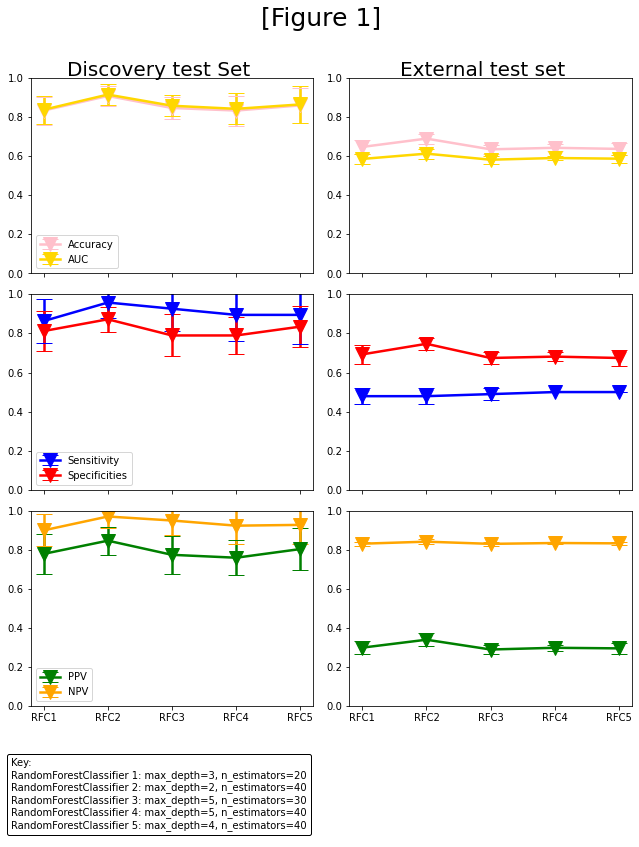

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9, 9.8))
fig.suptitle('[Figure 1]', fontsize=25, y=1.03)

column_titles = ['Discovery test Set', 'External test set']
for i, title in enumerate(column_titles):
    fig.text(0.5*(i+0.5), 0.94, title, ha='center', va='center', fontsize=20)

labels = ["RFC1", "RFC2", "RFC3", "RFC4", "RFC5"]

ax[0,0].errorbar(range(len(best_rfcs)), means_stds1['mean_accuracies'], yerr=means_stds1['std_accuracies'], marker='v', markersize=14, color='pink', capsize=8, linewidth=2.5, label='Accuracy')
ax[0,0].errorbar(range(len(best_rfcs)), means_stds1['mean_aucs'], yerr=means_stds1['std_aucs'], marker='v', markersize=14,color='gold', capsize=8, linewidth=2.5, label='AUC')
ax[0,0].set_ylim(0, 1)
ax[0,0].set_xticks(range(0, 5))
ax[0,0].set_xticklabels([])
ax[0,0].legend()

ax[1,0].errorbar(range(len(best_rfcs)), means_stds1['mean_sensitivities'], yerr=means_stds1['std_sensitivities'], marker='v', markersize=14, color="blue", capsize=8, linewidth=2.5, label='Sensitivity')
ax[1,0].errorbar(range(len(best_rfcs)), means_stds1['mean_specificities'], yerr=means_stds1['std_specificities'], marker='v', markersize=14, color="red", capsize=8, linewidth=2.5, label='Specificities')
ax[1,0].set_ylim(0, 1)
ax[1,0].set_xticks(range(0, 5))
ax[1,0].set_xticklabels([])
ax[1,0].legend()

ax[2,0].errorbar(range(len(best_rfcs)), means_stds1['mean_ppvs'], yerr=means_stds1['std_ppvs'], marker='v', markersize=14, color="green", capsize=8, linewidth=2.5, label='PPV')
ax[2,0].errorbar(range(len(best_rfcs)), means_stds1['mean_npvs'], yerr=means_stds1['std_npvs'], marker='v', markersize=14, color="orange", capsize=8, linewidth=2.5, label='NPV')
ax[2,0].set_ylim(0, 1)
ax[2,0].set_xticks(range(0, 5))
ax[2,0].set_xticklabels(labels)
ax[2,0].legend()

ax[0,1].errorbar(range(len(best_rfcs)), means_stds2['mean_accuracies'], yerr=means_stds2['std_accuracies'], marker='v', markersize=14, color="pink", capsize=8, linewidth=2.5)
ax[0,1].errorbar(range(len(best_rfcs)), means_stds2['mean_aucs'], yerr=means_stds2['std_aucs'], marker='v', color="gold", markersize=14, capsize=8, linewidth=2.5)
ax[0,1].set_ylim(0, 1)
ax[0,1].set_xticks(range(0, 5))
ax[0,1].set_xticklabels([])


ax[1,1].errorbar(range(len(best_rfcs)), means_stds2['mean_sensitivities'], yerr=means_stds2['std_sensitivities'], marker='v', markersize=14, color="blue", linewidth=2.5, capsize=8)
ax[1,1].errorbar(range(len(best_rfcs)), means_stds2['mean_specificities'], yerr=means_stds2['std_specificities'], marker='v', markersize=14, color="red", linewidth=2.5, capsize=8)
ax[1,1].set_ylim(0, 1)
ax[1,1].set_xticks(range(0, 5))
ax[1,1].set_xticklabels([])

ax[2,1].errorbar(range(len(best_rfcs)), means_stds2['mean_ppvs'], yerr=means_stds2['std_ppvs'], marker='v', markersize=14, color="green", linewidth=2.5, capsize=8)
ax[2,1].errorbar(range(len(best_rfcs)), means_stds2['mean_npvs'], yerr=means_stds2['std_npvs'], marker='v', markersize=14, color="orange", linewidth=2.5, capsize=8)
ax[2,1].set_ylim(0, 1)
ax[2,1].set_xticks(range(0, 5))
ax[2,1].set_xticklabels(labels)

rfc_descriptions = ["RandomForestClassifier 1: max_depth=3, n_estimators=20", 
    "RandomForestClassifier 2: max_depth=2, n_estimators=40", "RandomForestClassifier 3: max_depth=5, n_estimators=30", 
    "RandomForestClassifier 4: max_depth=5, n_estimators=40", "RandomForestClassifier 5: max_depth=4, n_estimators=40"
]

key_text = "Key:\n" + "\n".join(rfc_descriptions)
ax_key = fig.add_axes([0.2, -0.15, 0.1, 0.15], frame_on=False)  
ax_key.axis("off")

at = AnchoredText(key_text, prop=dict(size=10), frameon=True, loc='lower center')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax_key.add_artist(at)

plt.savefig('figure1.png', dpi=300, transparent=True)

plt.tight_layout()
plt.show()

The model we ended up selecting was RandomForestClassifier 5. This model had a high accuracy and also a small difference between the sensitivity and specificity.